In [1]:
using Distributions, LinearAlgebra, Statistics, Plots, StatsPlots, Random, Optim;

In [2]:
pyplot();

## Introduction

<p>ㅤㅤㅤㅤIn our class, we have explored different methods for inverse problems. As the professor told us that inverse problems were the same as parameter estimations in the first meeting, we have tried to find parameter values of a given model. In real life, however, it is often likely that there is no model given, and all you have is your input and output data. In addition, your goal might be just estimating output values given input values rather than finding an analytical function. In these cases, nonparametric regression could be useful because you do not assume a certain parametric form for a model. 
	I am going to explore three nonparametric regression methods: k-nearest-neighbors (hereinafter called “knn”),  the Nadaraya-Watson kernel regression (hereinafter called “kernel smoothing”), and local regression.  </p>

#### 1. Knn Regression
ㅤㅤㅤㅤKnn regression is defined as $$\hat f(x) = \frac{1}{k} \sum_{i \in N_k(x)}y_i$$ This means that the estimated output value of a given input $x$ is the average $y$ values of the $k$ points closest to $x$, where $k>0$ is the number of data points that you consider. For instance, if you have pairs of input-output data ${(x,y)=(1,3), (2,4), (3,5)}$, then $\hat f(1.5)$ with $k=2$ would be $3.5$ because the two $x$ points closest to $1.5$ are $1$ and $2$, and the average of y values corresponding with the $x$ points is $(3+4)/2 = 3.5$.


#### 2. Kernel Smoothing
ㅤㅤㅤㅤFor simplicity, we assume $d=1$, which means input data is a single value. A kernel function $K: \mathbb{R} \rightarrow \mathbb{R}$ used in kernel smoothing has properties: $\int K(x)dx = 1, \int xK(x)dx=0, \,\text{and}\, 0 < \int x^2K(x)dx < \infty$. The most common kernel function is the Gaussican kernel, $K(x) = \frac{1}{\sqrt{2\pi}}exp(-x^2/2)$. Then, with bandwidth parameter $h>0$, kernel regression is defined as $$\hat f(x) = \frac{\sum_{i=1}^n K(\frac{x_i-x}{h})y_i}{\sum_{i=1}^n K(\frac{x_i-x}{h})}$$ 

This means the estimated output value is the weighted average output values around x. To understand it easily, I want to think about an example of an unweighted average first. Assume we roll a die ten times and calculate the average value facing up. What do we do? We would count the frequency of each value, multiply each frequency by each value, add them up, and divide the sum by the total frequency that is 10 in this case. We could think of kernel regression in the same way. That is, K((xi-x)/h) could be thought as “frequency”, and yi could be thought as a value. If K is the Gaussican kernel, then K((xi-x)/h) returns a value indicating how close to x xi is. For example, if xi = x, then K would return the largest value, K(0), than any other K((xi-x)/h) since 0 is the mode of a normal distribution. On the other hand, if xi << x or xi >>x, then xi-x/h would become too large or too small, and K((xi-x)/h) would become almost 0, which means kernel regression would not consider information of that xi since it is too far from x. Finally, the denominator becomes the sum of “frequencies”, and we could think of kernel regression as weighted average around x. The role of bandwidth $h$ is that it changes the weight for the points around $x$. For example, if $h$ is small, the absolute value of $(xi-x)/h$ would become large, which would make the weight, $K((xi-x)/h)$, small. Therefore, the kernel function put more weight on the fewer points closer to $x$ and less weight on the more points far from $x$. On the other hand, if $h$ is large, $K((xi-x)/h)$ would become large. Therefore, it would put more weight on more points that are not closer to $x$. 


#### 3. Local Regressions
ㅤㅤㅤㅤLocal regression is a slight extention of the kernel regression. Another way of interpreting the kernel regression would be at each input $x$, it employs the estimate $\hat f(x) = \hat \theta$, where $\hat \theta$ is the minimizer of $$\sum_{i=1}^n K(\frac{x-x_i}{h})(y_i-\theta)^2$$

Now, we can think of the local estimate $\hat f(x)=\hat \alpha+\hat \beta x$, where $\hat \alpha, \hat \beta$ minimize $$\sum_{i=1}^nK(\frac{x-x_i}{h})(y_i-\alpha-\beta x_i)^2$$

This is called local linear regression, and we can extend local linear regression to local polynomial regression by fitting $\hat f(x)=\hat \beta_0 + \sum_{j=1}^p\hat \beta_jx^j$, where $\hat \beta_0, ...,\hat \beta_p$ minimize $$\sum_{i=1}^nK(\frac{x-x_i}{h})(y_i-\beta_0-\sum_{j=1}^p\beta_jx_i^j)^2$$

## Method

ㅤㅤㅤㅤI am going to simulate the three methods I have introduced above to abserve which one and what parameter can reproduce a model curve the most precisely. To make this simulation easy to observe, I made some assumptions.
* $d=1$ is assumed for all of the three methods.
* The Gaussican kernel will be used for the kernel regression and local regression.
* Only local linear regression will be simulated for local regression.
* The values of $k$ to be used for Knn regression will be $1, 5, 10, 20, \,\text{and}\, 35$.
* The values of $h$ to be used for the kernel regression and local linear regression will be $0.1, 0.5, 1, 2.5,\,\text{and}\, 5$.
* The model to be used will be non-linear function, $f(x)=\frac{3x^3-x^2+3x}{x+10}+\epsilon$, where $\epsilon \sim Normal(0,10)$.
* The input data, $x_i$, is ramdomly sampled from a uniform distribution where $a=-5,b=5$. 
* The number of data points will be 100.



In [4]:

model(x) = (3*x^3-x^2+3*x)/(x+10);

  0.000072 seconds (30 allocations: 1.918 KiB)


model (generic function with 1 method)

In [5]:
N = 100
xdata = rand(Uniform(-5,5),N)
ydata = model.(xdata) .+ rand(Normal(0,10),N);

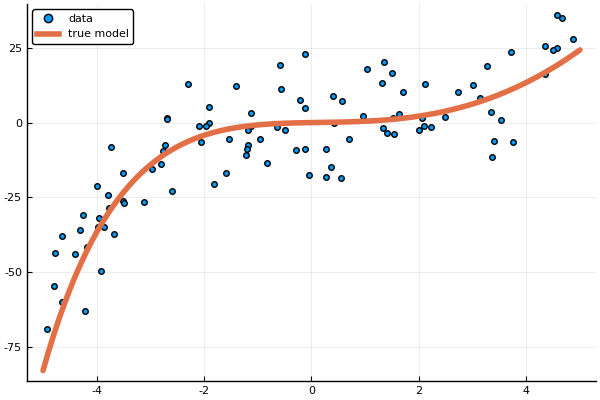

In [22]:
xvec = -5:0.1:5
scatter(xdata,ydata, label="data")
plot!(xvec, model.(xvec), label="true model", linewidth=4)

In [21]:
function knn_reg(x; xdata=xdata,ydata=ydata,k=1, N=N)
    sq = (x' .- xdata).^2
    norm = [sum(sq[i,:]) for i=1:size(sq)[1]]
    
    idx = sortperm(norm)[1:k]
    return sum(ydata[idx])/k, norm[idx[k]]
end

knn_reg (generic function with 1 method)

In [24]:
@time begin
ary = zeros(length(xvec))
far1 = zeros(length(xvec))

for i =1:length(xvec)
    ary[i],far1[i] = knn_reg(xvec[i], k=30)
end
end
# plot!(xvec, ary, label="knn regression with k=5", linewidth=4, alpha=0.5)

  0.001095 seconds (12.12 k allocations: 1.281 MiB)


In [25]:
model2(x) = (3*x[1]^3-3*x[2]^2+3*x[1])/(x[2]+10)
xdata2 = rand(Uniform(-5,5), N,2)
# xdata = [xdata 3*xdata.+2]
ydata2 = [model2(xdata2[i,:]')+rand(Normal(0,10)) for i in 1:N]
xvec =-5:0.1:5
z = zeros(length(xvec),length(xvec))
for i in 1:length(xvec), j in 1:length(xvec)
    z[i,j] = model2([xvec[i],xvec[j]])
end
xdata2
ydata2[1], model2(xdata2[1,:])
sort(ydata2);

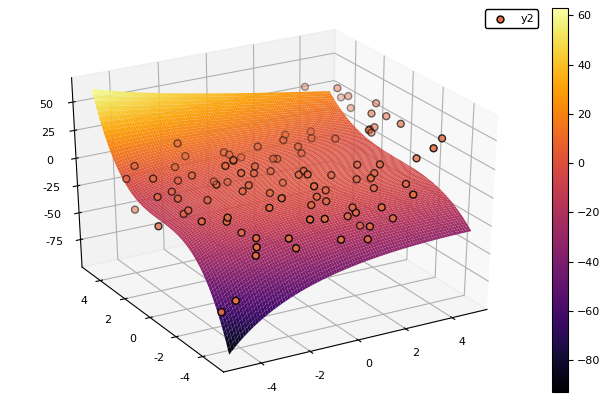

In [26]:
plot(xvec,xvec,z,seriestype=:surface,camera=(-30,30))
plt3d= Plots.plot!(xdata2[:,1],xdata2[:,2], ydata2,seriestype=:scatter, markersize = 5, camera=(-30,30))

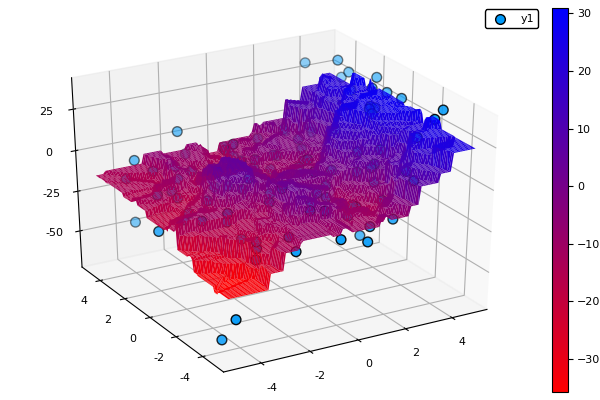

In [27]:
function my_cross(a,b)
    result = zeros(length(a)*length(b),2)
    
    for i=1:length(a)
        for j=1:length(b)
            result[(i-1)*length(a)+j,1]=a[i]
            result[(i-1)*length(a)+j,2]=b[j]
        end
    end
    return result
end

##all combinations
d = my_cross(xvec,xvec);

z_knn = zeros(size(d)[1])
far2 = zeros(size(d)[1])
for i=1:length(z_knn)
   z_knn[i], far2[i]= knn_reg(d[i,:],xdata=xdata2,ydata=ydata2,k=5)
   
end

z_knn = reshape(z_knn,length(xvec),length(xvec))
my_cg = cgrad([:red,:blue])
plt3d= Plots.plot(xdata2[:,1],xdata2[:,2], ydata2,seriestype=:scatter, markersize = 7, camera=(-30,30))
plot!(xvec,xvec,z_knn,seriestype=:surface, alpha=0.5, c=my_cg, camera=(-30,30))

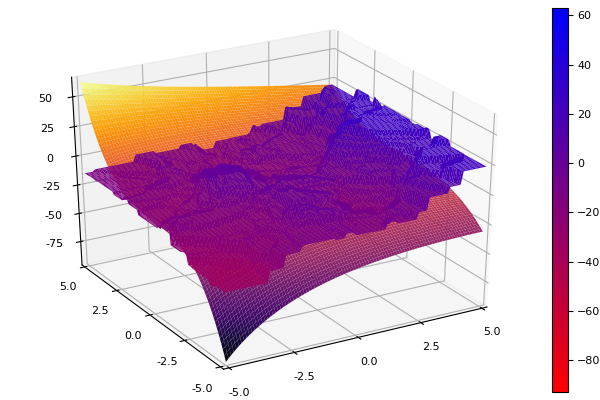

In [28]:
plot(xvec,xvec,z_knn,seriestype=:surface, alpha=0.5, c=my_cg, camera=(-30,30))
plot!(xvec,xvec,z,seriestype=:surface, camera=(-30,30))

In [29]:
# sum((ydata2.^2)

z4e = zeros(N)
temp = zeros(N)
far2 = zeros(N)
errors3d = zeros(N)
for j =1:length(1:N)
    for i=1:length(z4e)
        z4e[i],temp[i] = knn_reg(xdata2[i,:],xdata=xdata2,ydata=ydata2,k=j)
    end
    errors3d[j]=sum((ydata2 .- z4e) .^2)
    far2[j] = mean(temp)
    temp = zeros(N)
    z4e = zeros(N)
end

far1 = zeros(N)
errors2d = zeros(N)
for j =1:length(1:N)
    for i=1:length(z4e)
        z4e[i],temp[i] = knn_reg(xdata[i],k=j)
    end
    errors2d[j]=sum((ydata .- z4e) .^2)
    far1[j]=mean(temp)
    z4e = zeros(N)
end

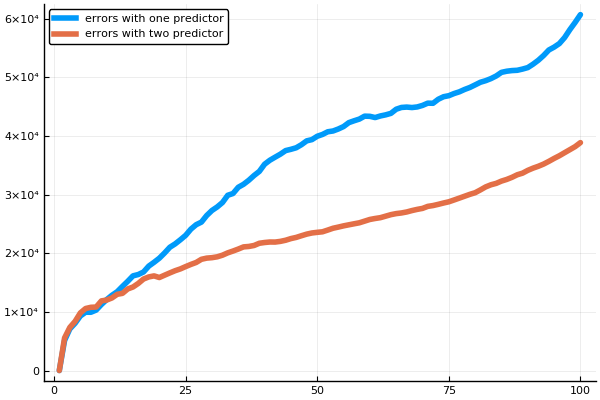

In [50]:
plot(errors2d, label="errors with one predictor", linewidth=4)
plot!(errors3d, label="errors with two predictor", linewidth=4)

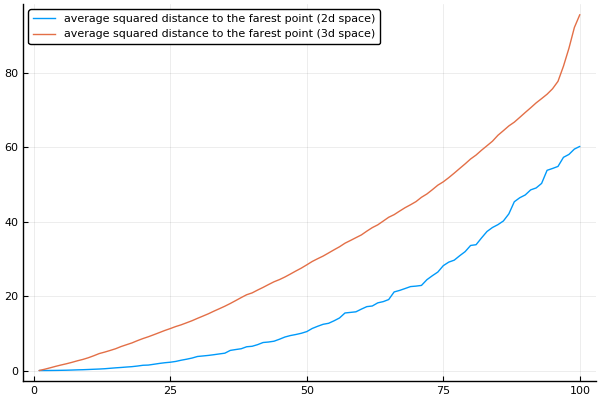

In [51]:
plot(far1, label ="average squared distance to the farest point (2d space)")
plot!(far2, label = "average squared distance to the farest point (3d space)")

In [64]:
n_pdf(x) = pdf(Normal(),x)


function Nadaraya_Watson(x; k=n_pdf,h=1)
    
    ary = (x .- xdata)/h
    num = sum(k.(ary) .* ydata)
    denom = sum(k.(ary))
    return num/denom

end

sum(Nadaraya_Watson(1))


100-element Array{Float64,1}:
 -1.8550344819770395 
  4.904147493131669  
 -2.095559897137427  
  1.1670015998659107 
 -1.9981540556370723 
 -3.755921834581329  
 -0.7464152433498503 
 -1.494001684714144  
  5.954337705943079  
  3.5379585719345976 
  1.7948335307846683 
 -1.681505774659609  
 -3.9425992141151838 
  ⋮                  
 -2.614825709941334  
 -3.2435013063242053 
  3.3362747991678168 
 -0.5437847075297251 
 -0.3923425531422273 
 -3.8828362532861824 
 -3.1195794571757087 
  0.43851719972854397
 -1.7290420583828645 
  2.0700373683216524 
  0.8532709529237668 
  1.7284344391225979 

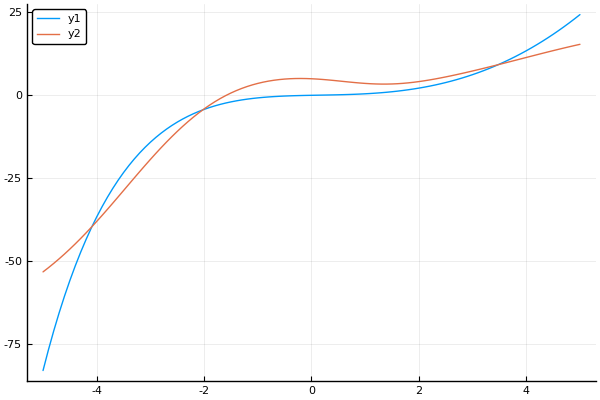

In [54]:
plot(xvec, model.(xvec))
plot!(xvec, Nadaraya_Watson.(xvec, h=1))

In [98]:
xvec = -5:0.1:5
f(x,b1=10,b2=5) = b1 + b2*x

function local_regression(f; order=1, k=n_pdf, xvec=xvec, xdata=xdata, ydata=ydata)
    betas = zeros(length(xvec),order+1)
    for i=1:length(xvec)
        g(b) = sum(k.(xvec[i].-xdata) .* (ydata .- f.(xdata, b[1],b[2])).^2)
        betas[i,:] = optimize(g,[1.0,1.0]).minimizer 
    end
    return betas
end
lo = ((local_regression(f).*[ones(length(xvec)) xvec])[:,1] .+ (
local_regression(f).*[ones(length(xvec)) xvec])[:,2])

101-element Array{Float64,1}:
 -78.90665598538432 
 -74.86435641820268 
 -70.8989062021523  
 -67.0208079146816  
 -63.2392521444806  
 -59.56189362503039 
 -55.99491572405921 
 -52.543101951428554
 -49.20985427148534 
 -45.997409722088406
 -42.90686099951911 
 -39.93840427249353 
 -37.091569651195215
   ⋮                
  12.94080874013101 
  13.619024735331228
  14.314163379677192
  15.029444377835134
  15.768477054845144
  16.535260530606134
  17.334177097640165
  18.169823269343603
  19.047208733727217
  19.971627690660505
  20.94855425314725 
  21.983755164964535

In [81]:
g(b) = sum(n_pdf.(xvec[1].-xdata) .* (ydata .- f.(xdata, b[1],b[2])).^2)

g (generic function with 1 method)

In [86]:
out = optimize(g,[1.0,1.0])
out.minimizer[1] + out.minimizer[2]*xvec[1]
out.minimizer

2-element Array{Float64,1}:
 103.97023585079039
  36.57537836723494

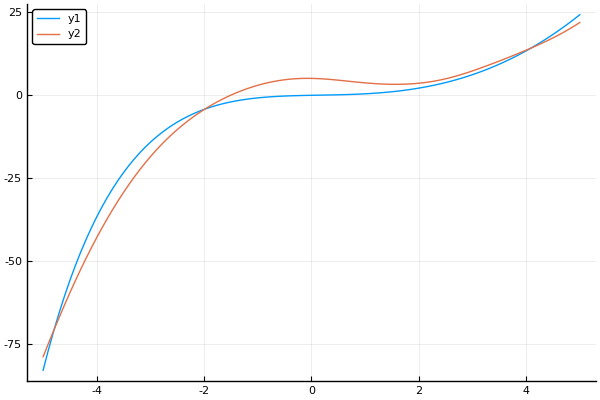

In [101]:
plot(xvec, model.(xvec))
plot!(xvec, lo)